In [ ]:
!unzip Garbage\ classification.zip -d data

Archive:  Garbage classification.zip
   creating: data/Garbage classification/cardboard/
  inflating: data/Garbage classification/cardboard/cardboard1.jpg  
  inflating: data/Garbage classification/cardboard/cardboard10.jpg  
  inflating: data/Garbage classification/cardboard/cardboard100.jpg  
  inflating: data/Garbage classification/cardboard/cardboard101.jpg  
  inflating: data/Garbage classification/cardboard/cardboard102.jpg  
  inflating: data/Garbage classification/cardboard/cardboard103.jpg  
  inflating: data/Garbage classification/cardboard/cardboard104.jpg  
  inflating: data/Garbage classification/cardboard/cardboard105.jpg  
  inflating: data/Garbage classification/cardboard/cardboard106.jpg  
  inflating: data/Garbage classification/cardboard/cardboard107.jpg  
  inflating: data/Garbage classification/cardboard/cardboard108.jpg  
  inflating: data/Garbage classification/cardboard/cardboard109.jpg  
  inflating: data/Garbage classification/cardboard/cardboard11.jpg  
  inf

In [ ]:
!ls data

cardboard  glass  metal  paper	plastic  trash


In [ ]:
!pip install tensorflow keras matplotlib


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Image Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    'data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    'data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Model: Use MobileNetV2 as feature extractor first
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze all layers initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Higher dropout to avoid overfitting
    Dense(train_gen.num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# Stage 1: Train top layers
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

# Stage 2: Fine-tune last layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False  # Train only last 50 layers

optimizer_finetune = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# Save model
model.save('waste_sorter_optimized.keras')


Found 2024 images belonging to 7 classes.
Found 503 images belonging to 7 classes.
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.2590 - loss: 2.0191 - val_accuracy: 0.6004 - val_loss: 1.1620 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5926 - loss: 1.1215 - val_accuracy: 0.6342 - val_loss: 0.9559 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.6502 - loss: 0.9287 - val_accuracy: 0.6541 - val_loss: 0.9033 - learning_rate: 1.0000e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7084 - loss: 0.8026 - val_accuracy: 0.6720 - val_loss: 0.8216 - learning_rate: 1.0000e-04
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7104 - loss: 0.7451 - val_accuracy: 0.6859 - val_loss: 0.7863 - learning_rate: 1.0000e-04
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7571 - loss: 0.6846 - val_accuracy: 0.6918 - val_loss: 0.7554 - learning_rate

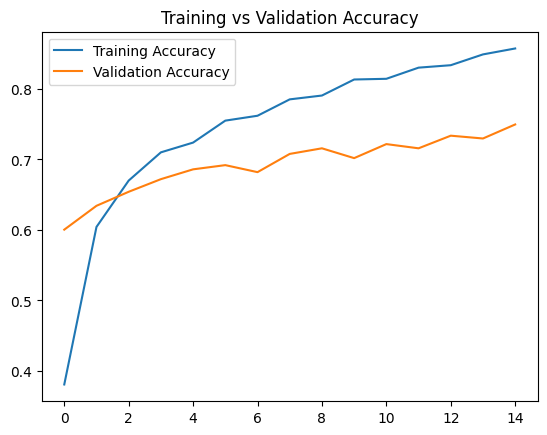

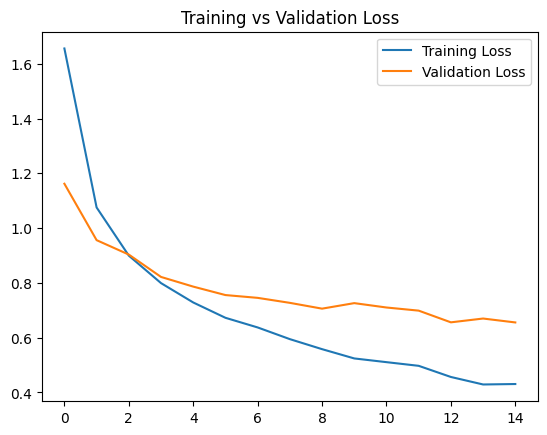

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
model.save('waste_sorter_best.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# model = load_model('waste_sorter_best.h5')

img_path = 'data/paper/paper5.jpg'  # replace with actual path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)
class_names = list(train_gen.class_indices.keys())
print("Predicted class:", class_names[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: paper


In [ ]:
print(train_gen.class_indices)


{'.ipynb_checkpoints': 0, 'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
